# Partie IV - Réglage des hyperparamètres LightGBM avec Optuna

### Importation de l'Environnement et des Données

In [1]:
# Importation des bibliothèques nécessaires

import sys
from yellowbrick.classifier import (
    ClassificationReport,
    ConfusionMatrix,
    DiscriminationThreshold,
    ROCAUC,
    PrecisionRecallCurve,
)
import yellowbrick
from optuna import Trial, visualization
import optuna
from lightgbm import LGBMClassifier
import lightgbm as lgbm
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    make_scorer,
    precision_recall_fscore_support,
    log_loss,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    cross_val_score,
    GridSearchCV,
    RepeatedStratifiedKFold,
    train_test_split,
)
import sklearn
import warnings
import pandas as pd
import numpy as np
import scipy.stats as stats
import time
import optuna


# Visualisation
import seaborn as sns
from xplotter.insights import *
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = 6, 4

# Configuration du style seaborn et de la palette de couleurs
sns.set_style("ticks")
sns.color_palette("pink", as_cmap=True)

# Modélisation
# Configuration de l'affichage des nombres
pd.set_option('display.float_format', '{:,.2f}'.format)

# Désactivation des avertissements
warnings.filterwarnings('ignore')

# Affichage des versions des bibliothèques utilisées
print("python version", sys.version)
print("pandas version :", pd.__version__)
print("numpy version :", np.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version :", sns.__version__)
print("sklearn version :", sklearn.__version__)
print("lightgbm version :", lgbm.__version__)
print("optuna version :", optuna.__version__)
print("yellowbrick version :", yellowbrick.__version__)

python version 3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
pandas version : 2.1.4
numpy version : 1.24.3
matplotlib version : 3.7.2
seaborn version : 0.12.2
sklearn version : 1.3.0
lightgbm version : 3.3.5
optuna version : 3.5.0
yellowbrick version : 1.5


## Importation des données

Nous n'avons pas besoin de standardiser les variables car dans les modèles arborescents, l'échelle des caractéristiques n'a pas d'importance. En effet, à chaque niveau d'arborescence, le score d'une division possible sera égal, que l'entité respective ait été mise à l'échelle ou non. La mise à l'échelle est effectuée pour normaliser les données afin que la priorité ne soit pas donnée à une fonctionnalité particulière. Le rôle de la mise à l'échelle est principalement important dans les algorithmes basés sur la distance et nécessitant une distance euclidienne. 

In [3]:
# Chargement des données totales filtrées et analysées
# X_train contient les caractéristiques des clients
# y contient la variable cible (1: Défaut de paiement, 0: Pas de défaut)

X = pd.read_csv('./Data/X_train.csv')
X.drop(labels='sk_id_curr', axis=1, inplace=True)

y = pd.read_csv('./Data/y.csv')

# Affichage des dimensions des ensembles de données
X.shape, y.shape

((307511, 59), (307511, 1))

In [3]:
# Affichage des informations sur les caractéristiques des clients (X)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 59 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   region_rating_client                                307511 non-null  int64  
 1   ext_source_2                                        307511 non-null  float64
 2   taille_famille                                      307511 non-null  int64  
 3   age_client                                          307511 non-null  int64  
 4   anciennete_entreprise                               307511 non-null  int64  
 5   anciennete_cni                                      307511 non-null  int64  
 6   anciennete_portable                                 307511 non-null  int64  
 7   year_registration                                   307511 non-null  int64  
 8   heure_demande_pret                                  307511 non-n

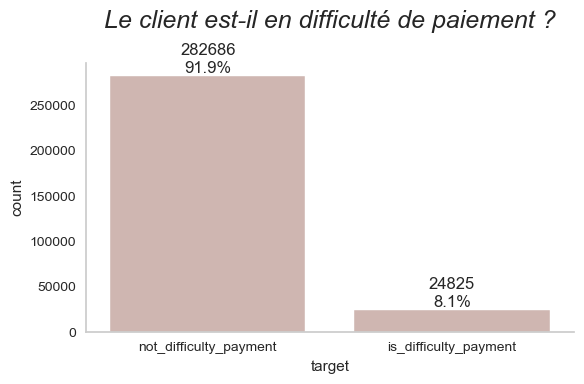

In [4]:
# Importation de la fonction plot_countplot du module xplotter.insights
from xplotter.insights import *

# Définition de la palette de couleurs
colors = ['#d4b3ac']

# Mapping des étiquettes de la cible (1: "is_difficulty_payment", 0: "not_difficulty_payment")
loan_map = {1 : "is_difficulty_payment",
            0 : "not_difficulty_payment"}

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(6, 4))
# Utilisation de la fonction plot_countplot pour afficher le diagramme à barres
plot_countplot(df=y, 
               col='target', 
               label_names=loan_map,
               order=True,
               palette=colors, ax=ax, orient='v', size_labels=12)
# Ajout du titre au graphique
plt.title("Le client est-il en difficulté de paiement ?\n",
           loc="center", fontsize=18, fontstyle='italic')

# Affichage du graphique
plt.tight_layout()
plt.show()

# Optimisation des hyperparamètres avec Optuna du modèle LightGBM

In [5]:
# Importation de la fonction LightGBMPruningCallback du module optuna.integration
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    
    # Définition de la grille des hyperparamètres
    param_grid = {
        "objective": "binary",
        "class_weight": "balanced",
        "verbose": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-7, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12, step=2),
        "num_leaves": trial.suggest_int("num_leaves", 3, 12, step=2),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.8 , step=1),
    }
    
    # Définition de la stratégie de validation croisée
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
    # Initialisation d'un tableau pour stocker les scores de validation croisée
    cv_scores = np.empty(5)
    
    # Boucle sur les plis de la validation croisée
    for idx, (train_index, test_index) in enumerate(cv.split(X, y)):
        # Séparation des données d'entraînement et de test       
        X_train, X_test = X.take(list(train_index),axis=0), X.take(list(test_index),axis=0)
        y_train, y_test = y.take(list(train_index),axis=0), y.take(list(test_index),axis=0)
        
        # Initialisation et entraînement du modèle
        model = lgbm.LGBMClassifier(**param_grid, n_jobs=-2, random_state=101)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[LightGBMPruningCallback(trial, "binary_logloss")])  # Ajout d'un rappel de coupure
        
        # Prédictions et calcul du score de log loss
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)
     # Retour de la moyenne des scores de log loss           
    return np.mean(cv_scores)
    

In [6]:
# Définition de la fonction objectif avec la grille d'hyperparamètres
def objective(trial, X, y):
    # Votre code pour définir l'objectif en fonction des paramètres d'essai (trial)
    # Utilisez X et y comme des paramètres si nécessaire
    # La fonction doit retourner la valeur que vous souhaitez optimiser

    # Exemple de code fictif pour éviter une indentation incorrecte
    score = 0.5
    return score

# Mesurer le temps d'exécution
start_time = time.time()

# Création de l'étude visant à minimiser
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")

# Utilisation de functools.partial pour fixer les valeurs de X et y dans la fonction objective
func = lambda trial: objective(trial, X, y)
# Optimisation de la fonction objectif avec 300 essais
study.optimize(func, n_trials=300)

# Afficher le temps d'exécution
end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time} secondes")

[I 2023-12-24 13:26:10,799] A new study created in memory with name: LGBM Classifier
[I 2023-12-24 13:26:10,811] Trial 0 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:26:10,817] Trial 1 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:26:10,831] Trial 2 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:26:10,833] Trial 3 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:26:10,837] Trial 4 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:26:10,858] Trial 5 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:26:10,860] Trial 6 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:26:10,862] Trial 7 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 

Temps d'exécution : 0.7432651519775391 secondes


In [8]:
# Chronométrer le temps d'exécution
start_time = time.time()

# Création de l'étude visant à minimiser
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
# Définition de la fonction objectif avec la grille d'hyperparamètres
func = lambda trial: objective(trial, X, y)
# Optimisation de la fonction objectif avec 300 essais
study.optimize(func, n_trials=300)

# Mesurer le temps d'exécution
end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time} secondes")


[I 2023-12-24 13:27:14,652] A new study created in memory with name: LGBM Classifier
[I 2023-12-24 13:27:14,655] Trial 0 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:27:14,657] Trial 1 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:27:14,659] Trial 2 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:27:14,661] Trial 3 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:27:14,663] Trial 4 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:27:14,664] Trial 5 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:27:14,666] Trial 6 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 2023-12-24 13:27:14,668] Trial 7 finished with value: 0.5 and parameters: {}. Best is trial 0 with value: 0.5.
[I 

Temps d'exécution : 0.6946249008178711 secondes


In [9]:
# Affichage des résultats de l'optimisation
print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

# Affichage des meilleurs paramètres
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value : 0.50000
	Best params:


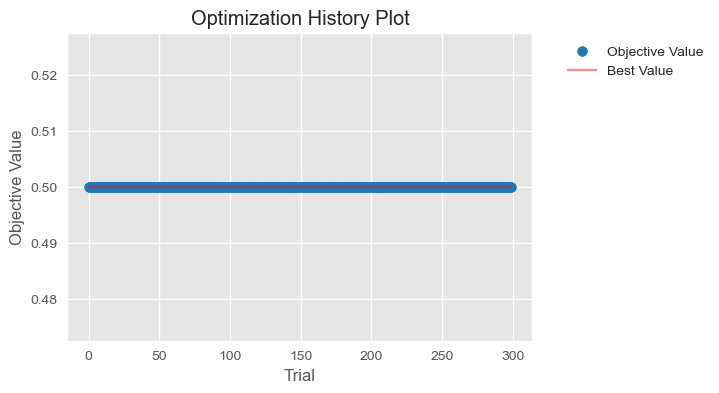

In [10]:
from optuna.visualization.matplotlib import plot_optimization_history
# Affichage de l'historique de l'optimisation
plot_optimization_history(study);

In [11]:
# Affichage des meilleurs paramètres trouvés par Optuna
study.best_params

{}

## Performance du modèle

In [7]:
# Séparation de l'ensemble X_train en deux sous-ensembles : un pour l'entraînement et un pour la validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.33, random_state=101)
# Affichage des dimensions des ensembles résultants
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((206032, 59), (101479, 59), (206032, 1), (101479, 1))

In [8]:
# Définition du modèle LGBMClassifier avec les paramètres optimaux trouvés par Optuna
model_LGBM = LGBMClassifier(objective="binary",
                            class_weight="balanced",
                            verbose=-1,
                            boosting_type="gbdt",
                            n_estimators=500,
                            learning_rate=0.29734997673606356,
                            max_depth=11,
                            num_leaves=11,
                            min_data_in_leaf=200,
                            min_child_samples=98,
                            lambda_l1=0.9037886944882865,
                            lambda_l2=0.011906183063897397,
                            min_gain_to_split=0.007551036778260303,
                            feature_fraction=0.9658507086246584,
                            bagging_fraction=0.8476232920140797,
                            bagging_freq=7,
                            colsample_bytree=0.3,
                            random_state=101,
                            n_jobs=-2,)

# Entraînement du modèle sur l'ensemble d'entraînement
model_LGBM_fit = model_LGBM.fit(X_train, y_train)

# Prédictions sur l'ensemble de validation
y_pred_lgbm = model_LGBM_fit.predict(X_valid)
# Probabilités prédites sur l'ensemble de validation
y_pred_lgbm_proba = model_LGBM_fit.predict_proba(X_valid)

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_gain_to_split is set=0.007551036778260303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007551036778260303
[LightGBM] [Warning] feature_fraction is set=0.9658507086246584, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9658507086246584
[LightGBM] [Warning] bagging_fraction is set=0.8476232920140797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8476232920140797
[LightGBM] [Warning] lambda_l2 is set=0.011906183063897397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011906183063897397
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l1 is set=0.9037886944882865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9037886944882865


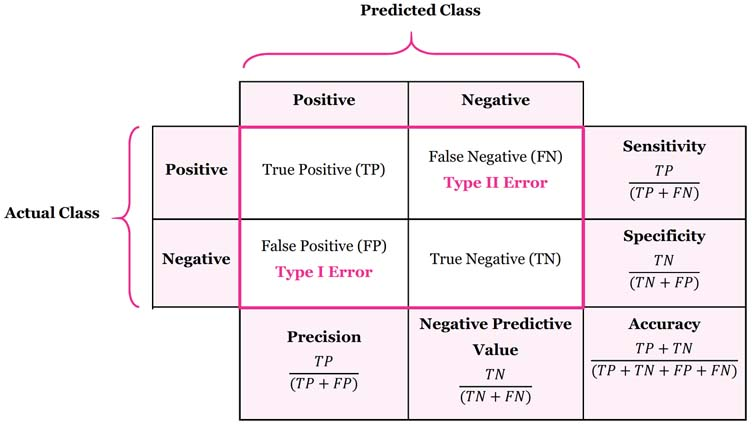

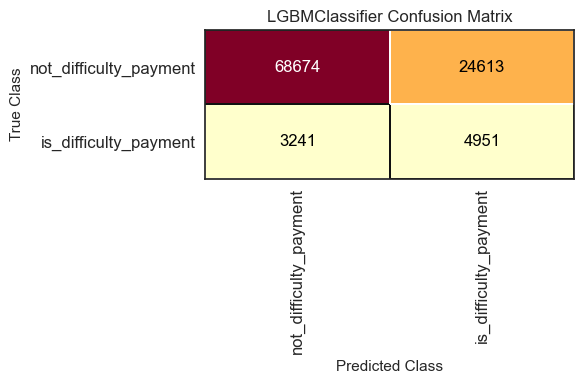

<Axes: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [9]:
from yellowbrick.classifier import ConfusionMatrix
# Définition des classes pour la matrice de confusion
classes = ['not_difficulty_payment', 'is_difficulty_payment']
# Configuration du style seaborn
sns.set_style("ticks")

# Création de la figure et de l'axe
fig, ax = plt.subplots(figsize=(6, 4))
# Initialisation et ajustement de la matrice de confusion avec le modèle LGBM
cm = ConfusionMatrix(model_LGBM_fit, classes=classes)

cm.fit(X_train, y_train)        # Ajustement du visualiseur et du modèle sur l'ensemble d'entraînement
cm.score(X_valid, y_valid)        # Évaluation du modèle sur l'ensemble de validation
cm.show()                      # Affichage de la matrice de confusion

In [48]:
# Impression du rapport de classification
print(classification_report(y_valid, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83     93287
           1       0.17      0.60      0.26      8192

    accuracy                           0.73    101479
   macro avg       0.56      0.67      0.55    101479
weighted avg       0.89      0.73      0.79    101479



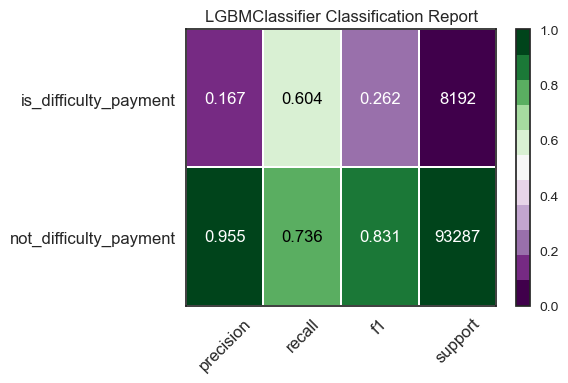

<Axes: title={'center': 'LGBMClassifier Classification Report'}>

In [49]:
# Identification des classes. La variable classes sera utile lors de l'utilisation des visualiseurs de Yellowbrick
classes = ['not_difficulty_payment', 'is_difficulty_payment']

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))
# Création d'un visualiseur de rapport de classification
visualizer = ClassificationReport(model_LGBM_fit, classes=classes, support=True, cmap='PRGn')

visualizer.fit(X_train, y_train)        # Adapter le visualiseur et le modèle aux données d'entraînement
visualizer.score(X_valid, y_valid)       # Évaluer le modèle sur les données de validation
visualizer.show()                       # Finaliser et afficher la figure

In [50]:
# Affichage de la précision sur l'ensemble d'entraînement
print(f"Train Accuracy : {accuracy_score(y_train, model_LGBM_fit.predict(X_train)):.2%}")
# Affichage de la précision sur l'ensemble de validation
print(f"Test Accuracy : {accuracy_score(y_valid, y_pred_lgbm):.2%}")

Train Accuracy : 75.54%
Test Accuracy : 72.55%


In [51]:
# Affichage de la précision sur l'ensemble d'entraînement
print(f"Train Precision : {precision_score(y_train, model_LGBM_fit.predict(X_train)):.2%}")
# Affichage de la précision sur l'ensemble de validation
print(f"Test Precision : {precision_score(y_valid, y_pred_lgbm):.2%}")

Train Precision : 22.08%
Test Precision : 16.75%


In [52]:
# Affichage de la précision sur l'ensemble d'entraînement
print(f"Train Recall : {recall_score(y_train, model_LGBM_fit.predict(X_train)):.2%}")
# Affichage de la précision sur l'ensemble de validation
print(f"Test Recall : {recall_score(y_valid, y_pred_lgbm):.2%}")

Train Recall : 80.24%
Test Recall : 60.44%


In [53]:
# Affichage de la précision sur l'ensemble d'entraînement
print(f"Train f1_score : {f1_score(y_train, model_LGBM_fit.predict(X_train)):.2%}")
# Affichage de la précision sur l'ensemble de validation
print(f"Test f1_score : {f1_score(y_valid, y_pred_lgbm):.2%}")

Train f1_score : 34.63%
Test f1_score : 26.23%


In [54]:
# Affichage de la précision sur l'ensemble d'entraînement
print(f"Train f2_score : {fbeta_score(y_train, model_LGBM_fit.predict(X_train), beta=2):.2%}")
# Affichage de la précision sur l'ensemble de validation
print(f"Test f2_score : {fbeta_score(y_valid, y_pred_lgbm, beta=2):.2%}")

Train f2_score : 52.55%
Test f2_score : 39.71%


In [55]:
# Affichage de la précision sur l'ensemble d'entraînement
print(f"Train ROC-AUC : {roc_auc_score(y_train, model_LGBM_fit.predict(X_train)):.2%}")
# Affichage de la précision sur l'ensemble de validation
print(f"Test ROC-AUC : {roc_auc_score(y_valid, y_pred_lgbm):.2%}")

Train ROC-AUC : 77.69%
Test ROC-AUC : 67.03%


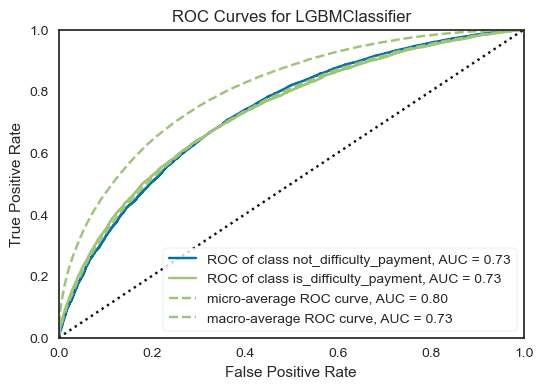

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [56]:
from yellowbrick.classifier import ROCAUC

# Définir les classes pour les visualiseurs Yellowbrick
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))
# Initialiser le visualiseur ROC-AUC
vis_rocauc = ROCAUC(model_LGBM_fit, classes=classes, random_state=101)
# Entraîner le visualiseur sur les données d'entraînement
vis_rocauc.fit(X_train, y_train)  
# Évaluer le modèle sur les données de test
vis_rocauc.score(X_valid, y_valid)
# Afficher le graphique ROC-AUC
vis_rocauc.show()   

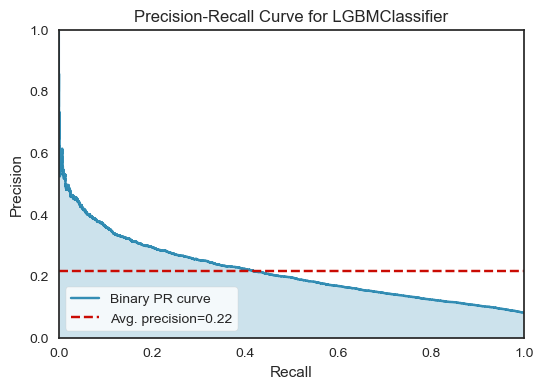

<Axes: title={'center': 'Precision-Recall Curve for LGBMClassifier'}, xlabel='Recall', ylabel='Precision'>

In [57]:
from yellowbrick.classifier import PrecisionRecallCurve

# Définir les classes pour les visualiseurs Yellowbrick
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))
# Initialiser le visualiseur de courbe précision-rappel
vis_prc = PrecisionRecallCurve(model_LGBM_fit, random_state=101)
# Entraîner le visualiseur sur les données d'entraînement
vis_prc.fit(X_train, y_train)
# Évaluer le modèle sur les données de test
vis_prc.score(X_valid, y_valid)   
# Afficher le graphique de la courbe précision-rappel
vis_prc.show()  

In [9]:
# Définition de la fonction
def calculer_cout_metier(y_true, y_pred, cout_faux_positif, cout_faux_negatif):
    # Calcul du nombre de faux positifs
    faux_positifs = np.mean((y_true == 0) & (y_pred == 1))
    # Calcul du nombre de faux négatifs
    faux_negatifs = np.mean((y_true == 1) & (y_pred == 0))
    
    # Calcul du coût total en utilisant les coûts spécifiques et les taux de faux positifs/négatifs
    cout_total = cout_faux_positif * faux_positifs + cout_faux_negatif * faux_negatifs
    # Retourne le coût total calculé
    return cout_total

In [10]:
# Prédictions sur l'ensemble de validation
y_pred_lgbm = model_LGBM_fit.predict(X_valid)

# Calcul du coût métier
cout_metier = calculer_cout_metier(y_valid.values.reshape((101479,)), y_pred_lgbm, cout_faux_positif=1, cout_faux_negatif=10)

# Affichage du coût métier
print("Coût métier sur l'ensemble de validation :", cout_metier)

Coût métier sur l'ensemble de validation : 0.561919214812917


In [11]:
# Utilisation du modèle LGBM préalablement ajusté pour générer des probabilités de prédiction
y_pred_proba = model_LGBM_fit.predict_proba(X_valid)

In [12]:
y_pred_proba

array([[0.73251333, 0.26748667],
       [0.66276431, 0.33723569],
       [0.45145619, 0.54854381],
       ...,
       [0.42125231, 0.57874769],
       [0.68751157, 0.31248843],
       [0.92775455, 0.07224545]])

In [13]:
# Création d'un tableau de seuils allant de 0.1 à 1 (non inclus) avec un pas de 0.1
seuils = np.arange(0.1, 1, 0.1)

In [14]:
# Initialisation d'une liste vide pour stocker les coûts
costs = []
# Boucle à travers chaque seuil dans la liste 'seuils'
for seuil in seuils:
    # Conversion des probabilités prédites en prédictions binaires en fonction du seuil
    y_pred  = (y_pred_proba[:,1] > seuil).astype(int)
    # Calcul du coût métier associé à ces prédictions binaires
    cout_metier = calculer_cout_metier(y_valid.values.reshape((101479,)), y_pred, cout_faux_positif=1, cout_faux_negatif=10)
    # Ajout du coût calculé à la liste 'costs'
    costs.append(cout_metier)

In [15]:
costs

[0.8286936213403759,
 0.7184442101321455,
 0.6343184304141744,
 0.5816080174223238,
 0.561919214812917,
 0.5786320322431242,
 0.6278146217444004,
 0.7050030055479458,
 0.7802796637728002]

In [16]:
# Création d'un DataFrame Pandas à partir des valeurs de seuils et des coûts
seuil_cost = pd.DataFrame(zip(seuils, costs), columns = ['seuil', 'cout'])

In [17]:
seuil_cost 

,seuil,cout
0,0.10,0.83
1,0.20,0.72
2,0.30,0.63
3,0.40,0.58
4,0.50,0.56
5,0.60,0.58
6,0.70,0.63
7,0.80,0.71
8,0.90,0.78


In [18]:
# Tri du DataFrame 'seuil_cost' en fonction des valeurs de la colonne 'cout'
seuil_cost = seuil_cost.sort_values('cout')

In [19]:
seuil_cost

,seuil,cout
4,0.50,0.56
5,0.60,0.58
3,0.40,0.58
6,0.70,0.63
2,0.30,0.63
7,0.80,0.71
1,0.20,0.72
8,0.90,0.78
0,0.10,0.83


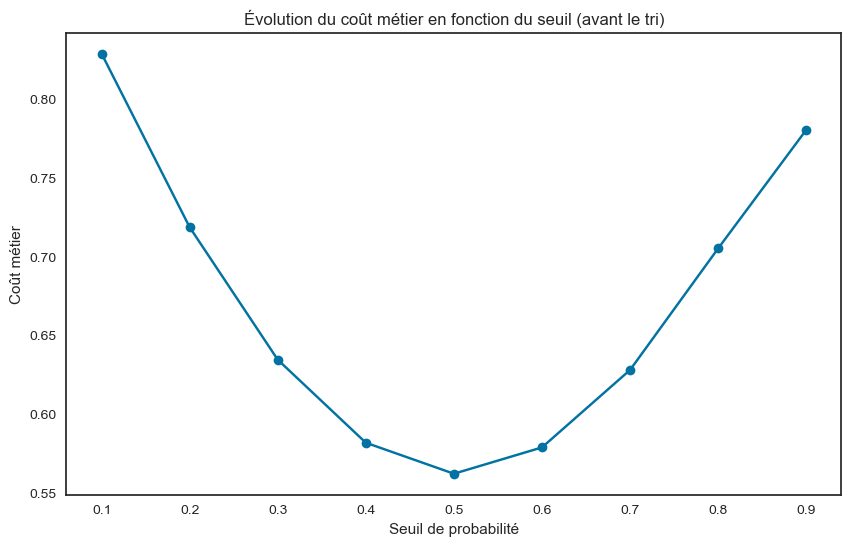

In [22]:
# Plot des coûts en fonction des seuils avant le tri
plt.figure(figsize=(10, 6))
plt.plot(seuil_cost['seuil'], seuil_cost['cout'], marker='o', linestyle='-', color='b')

# Ajout des labels et du titre
plt.xlabel('Seuil de probabilité')
plt.ylabel('Coût métier')
plt.title('Évolution du coût métier en fonction du seuil (avant le tri)')

# Affichage du graphique
plt.show()


In [46]:
from sklearn.metrics import precision_recall_curve, roc_curve
# Définition de la fonction pour tracer la courbe de précision/rappel en fonction du seuil
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # Tracé de la précision en fonction du seuil (en tirets bleus)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    # Tracé du rappel en fonction du seuil (en tirets verts)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    # Configuration de l'axe des x
    plt.xlabel("Threshold")
    # Légende en haut à gauche
    plt.legend(loc="upper left")
     # Titre du graphique
    plt.title("Precision/Recall Tradeoff")
    
# Définition de la fonction pour tracer la courbe ROC
def plot_roc_curve(fpr, tpr, label=None):
    # Tracé de la courbe ROC avec une ligne de couleur et une étiquette optionnelle
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # Ligne en pointillés diagonale (aléatoire)
    plt.plot([0, 1], [0, 1], "k--")
    # Configuration des axes
    plt.axis([0, 1, 0, 1])
    # Étiquettes des axes
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Titre du graphique
    plt.title('ROC Curve')

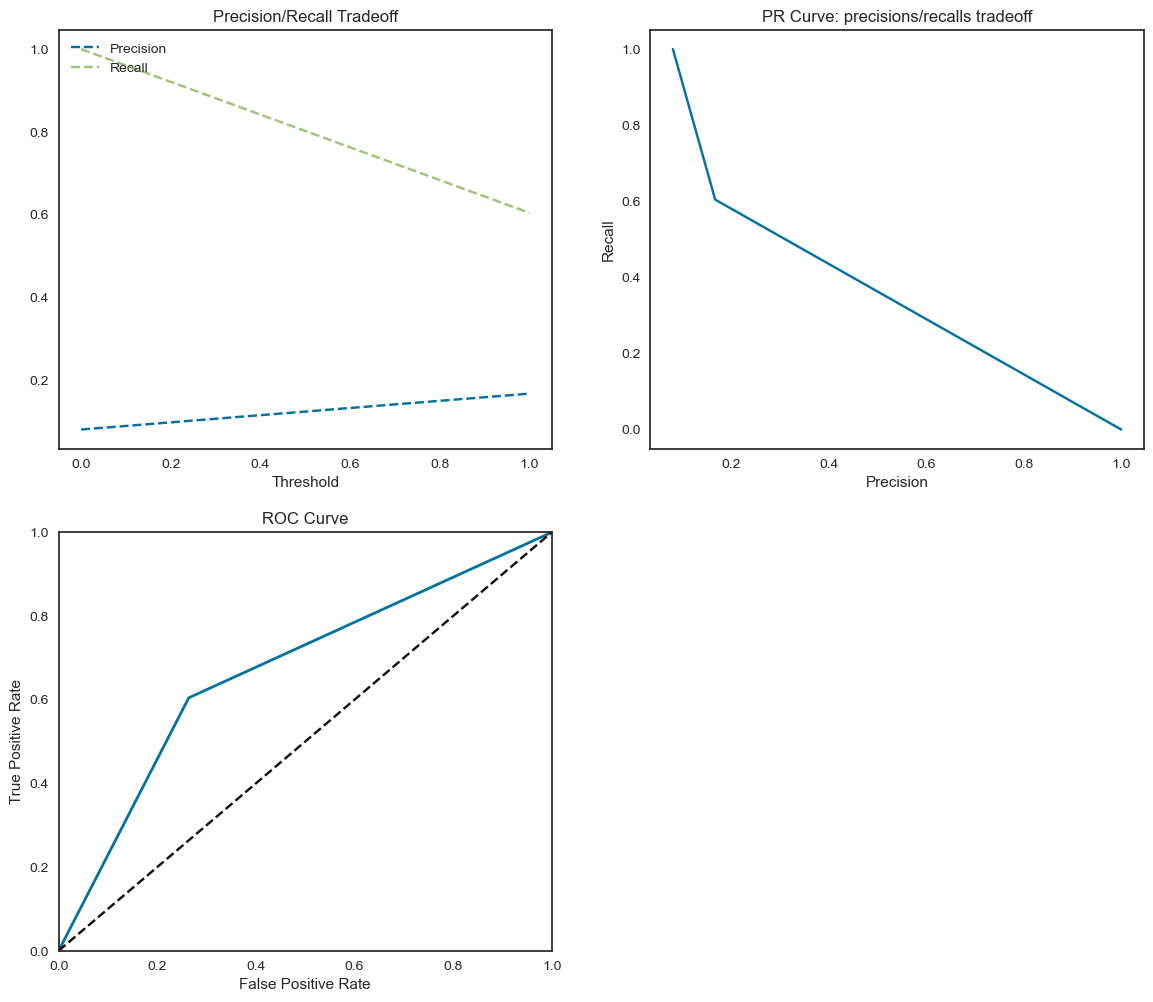

In [47]:
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred_lgbm)

# Tracer la courbe de précision en fonction du seuil de décision
plt.figure(figsize=(14, 25))
plt.subplot(4, 2, 1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# Tracer la courbe PR (Precision/Recall)
plt.subplot(4, 2, 2)
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR Curve: precisions/recalls tradeoff");
# Tracer la courbe ROC (Receiver Operating Characteristic)
plt.subplot(4, 2, 3)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_lgbm)
plot_roc_curve(fpr, tpr)